# Libraries

Run the following cell when in google colab

In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# When in colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# built in
import time
from itertools import cycle # for cycling through colors

# data and linear algebra
import numpy as np
import pandas as pd

# graphics
import seaborn as sns
import matplotlib.pyplot as plt

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

# vectorizer sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

# TensorFlow & keras
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# gensim
import gensim
from gensim.models import KeyedVectors

# BERT
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'


2023-02-27 18:52:06.593822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 18:52:06.800338: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-27 18:52:06.800359: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-27 18:52:07.896187: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Options

In [7]:
import warnings
warnings.filterwarnings('ignore')


## Functions

The following cell contains the functions that we use in this notebook.

In [57]:
def choose_best_thres(y_true, y_pred_proba):
    '''
    Returns a threshold between 0.1 and 0.9
    which maximizes the macro average f1-score,
    for a multilabel classification problem.

    Parameters:
        - y_true: binary array
        - y_pred_proba: array
            returned by some_estimator.predict_proba()
    '''
    f1_thr = {}
    for t in np.linspace(0.1,0.9,9): # testing thresholds 0.2, 0.3, up to 0.8
        classif_rep = classification_report(
            y_true, 
            (y_pred_proba > t).astype(int),
            target_names=tag_list,
            output_dict=True)
        f1_thr[t] =  classif_rep['macro avg']['f1-score']

    # choose threshold for maximal f1-score
    thresh = round(max(f1_thr, key=f1_thr.get),1)
    print(f'Threshold that maximizes f1-score: {thresh}')

    return thresh


def plot_classif_report(classif_report, tag_list, model_name, dataset_name, vectorization):
    '''
    Plots precision, recall and f1-score for each tag in tag_list.

    Parameters:
        - classif_report: dict
            It is the output of sklearn.metrics.classification_report(y_true,y_pred)
            after a multi-label multi-output classification.
        - tag_list: list of str
            The list of tags of the classification.
        - model_name, dataset_name: str
            for the title of the plot
    '''
    global f1_sco
    n_tags = len(tag_list)

    fig = plt.figure(figsize=(10, 6))
    plt.grid(True)
    plt.xticks(range(1,len(tag_list)+1),tag_list)
    colors = ['blueviolet', 'darkorange', 'dodgerblue']

    for metric,color in zip(['precision', 'recall', 'f1-score'], colors):
        y = [classif_report[tag][metric] for tag in tag_list]
        plt.scatter(range(1,n_tags+1),y,label=metric, c=color)
    plt.legend()
    plt.ylim(0,1.1)
    plt.xticks(rotation=70)

    macro_prec = round(classif_report['macro avg']['precision'],2)
    macro_rec = round(classif_report['macro avg']['recall'],2)
    macro_f1 = round(classif_report['macro avg']['f1-score'],2)
    f1_sco = macro_f1

    plt.text(30, 
             0.05, 
             f'Macro avg\nprecision: {macro_prec}\nrecall: {macro_rec}\nf1-score: {macro_f1}',
             bbox={'facecolor':'white', 'alpha':0.5})
    plt.title(f'Some metrics by tag\nModel: {model_name}, set: {dataset_name}, vectorization: {vectorization}')
    plt.show()

def diplay_and_plot_report(y_true, y_pred, model_name, dataset_name, vectorization):
        '''
        Displays the classification report together with the metrics
        (from the mul-label, multi-output classification) and plots
        the metrics for each tag.

        Parameters:
                - y_true: array
                        The true labels
                - y_pred: array
                        The prefictions
                - model_name, dataset_name: str
                        For the title of the plot
        '''

        classif_rep = classification_report(
                y_true, 
                y_pred,
                target_names=tag_list,
                output_dict=True)
        classif_rep_displ = classification_report(
                y_true, 
                y_pred,
                target_names=tag_list,
                output_dict=False)
        print(f'Classifier: {model_name}\tDataset: {dataset_name}')
        print('-'*70)
        print(classif_rep_displ)
        plot_classif_report(classif_rep, tag_list, model_name, dataset_name, vectorization)

def compute_roc_data(y_true,y_pred_proba,tag_list):
    '''
    Computes the data necessary to plot the OneVsRest
    ROC curves of our multilabel classification.
    Returns dictionnaries: fpr, tpr, roc_auc

    Based on sckikit-learn's example: 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

    Parameters:
        - y_true: pd.DataFrame
        - y_pred: array
            returned by classification: predict probabilities
        - tag_list: list of str 
    '''
    global roc_auc_res

    n_tags = len(tag_list)
    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.values.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")


    for i in range(n_tags):
        fpr[i], tpr[i], _ = roc_curve(y_true.values[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_tags):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_tags

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    roc_auc_res = roc_auc["macro"]

    print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

    return fpr, tpr, roc_auc



def plot_roc_curves(
        fpr, tpr, roc_auc, model_name, dataset_name, vector_name,y_true,y_pred_proba):
    '''
    Plots the ROC curves of the OneVsRest classification
    for each tag.

    Based on scikit-learn's example:
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

    Parameters:
        - fpr, tpr, roc_auc: dict, dict, dict
            Output of the function compute_roc_data
        - model_name, dataset_name: str
            For the title of the plot
    '''
    

    fig, ax = plt.subplots(figsize=(6, 6))

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=3,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=3,
    )

    # colors = cycle(["darkorange", 
    #                 'olivedrab', 
    #                 'lightseagreen',
    #                 'dodgerblue',
    #                 'slategray',
    #                 'blueviolet',
    #                 'indigo',
    #                 'mediumvioletred',
    #                 'lightgreen',
    #                 'lightpink'
    #                 ])
    
    colors = cycle(sns.color_palette("hls", 40))
    for (idx,class_id), color in zip(enumerate(tag_list), colors):
        RocCurveDisplay.from_predictions(
            y_true[f'tag_{class_id}'].values,
            y_pred_proba[:, idx],
            name=f"ROC curve for {class_id}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC curves and AUC for each tag to One-vs-Rest\nmodel: {model_name}, dataset: {dataset_name},\n vectorizarion: {vector_name}")
    plt.legend(loc='center left', bbox_to_anchor = (1,0.5))
    plt.show()


# Data

In [9]:
path = './data/'
# path = './drive/MyDrive/colab-notebooks/'  # When in colab
filename = 'processed_data_v011_sample.csv'

df = pd.read_csv(path + filename)
df.set_index('Id', inplace=True)

tag_list = [tag[4:] for tag in list(df.columns) if 'tag' in tag]

In [ ]:
# for listing tags from binary sequence
# from itertools import compress

# fil = [bool(x) for x in [1,0,0,0,0,0,1,0,0,0]]
# lista = list(compress(tag_list,fil))

# def binary_to_tag_list(binary):
#     fil = [bool(x) for x in list(binary)]
#     list_tags = list(compress(tag_list),fil)

In [10]:
df.head()

,processed_text,text,Title,Body,Score,ViewCount,AnswerCount,Tags,tag_c#,tag_java,...,tag_multithreading,tag_asp.net-mvc,tag_ruby,tag_database,tag_wpf,tag_unit-testing,tag_macos,tag_arrays,tag_c++11,tag_django
Id,,,,,,,,,,,,,,,,,,,,,
26371233,detect notification background music app write...,detect MPMusicPlayerController notifications i...,detect MPMusicPlayerController notifications i...,"<p>I have a music app written in swift, I am u...",12,1663,2,"['ios', 'objective-c', 'swift']",0,0,...,0,0,0,0,0,0,0,0,0,0
25250762,xcode swift window title bar minimize resize b...,Xcode & Swift - Window without title bar but w...,Xcode & Swift - Window without title bar but w...,"<p>I am currently using Swift in Xcode 6, Beta...",41,25715,7,['swift'],0,0,...,0,0,0,0,0,0,0,0,0,0
443235,configuration system fail initialize exception...,.NET 3.5 - Configuration system failed to init...,.NET 3.5 - Configuration system failed to init...,"<p>In my winform app, I am trying to add a use...",29,95163,12,['.net'],0,0,...,0,0,0,0,0,0,0,0,0,0
45223025,mongoose version error matching document find ...,Mongoose - Version Error: No matching document...,Mongoose - Version Error: No matching document...,<p><strong>Context</strong>: I have a <code>Po...,13,24111,6,"['javascript', 'node.js']",0,0,...,0,0,0,0,0,0,0,0,0,0
31262682,eclipse mars show jboss server thing try eclip...,Eclipse Mars not showing Jboss Server <p>Here ...,Eclipse Mars not showing Jboss Server,<p>Here is the things I tried</p>\n\n<ol>\n<li...,7,31012,4,['java'],0,1,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df.shape

(10000, 46)

# Bag of words: TF-IDF (supervised)

## Vectorizing texts

In [24]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(max_df=0.75,
                     min_df=0.0015
                     )

# Vectorize the processed text
X = tfidf.fit_transform(df.processed_text)

# Defining target vector
columns_tags = ['tag_'+tag for tag in tag_list]
y = df[columns_tags]

# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.33, random_state=5
)

In [25]:
X.shape

(10000, 2014)

## Classification

Our tag suggesting problem is a Multilabel classification problem. For this, we use the OneVsRest strategy (and tool by scikit-learn), which trains/predicts one estimator per label. See [OneVsRest scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier), the [scikit-learn module on article about multilabel classif](https://scikit-learn.org/stable/modules/multiclass.html#onevsrestclassifier) and a [scikit-learn example on multilabel classif.](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_multilabel.html#sphx-glr-auto-examples-miscellaneous-plot-multilabel-py)

For the **evaluation** of the models we base on the scikit-learn example : [ROC AUC for multilabel](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py), and we use the **macro average** for f1-score and ROC AUC. Since this way of averaging considers each tag as having the same importance (see this [stack exchange question](https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin)).

We used this Stackoverflow discussion about [Fine tuning estimator inside OneVsRestClassifier](https://stackoverflow.com/questions/12632992/gridsearch-for-an-estimator-inside-a-onevsrestclassifier).

- More on [Multiclass and multilabel classification](https://scikit-learn.org/stable/modules/model_evaluation.html#multiclass-and-multilabel-classification).

In [37]:
classification_results = {'Vectorization' : [],
                          'Model' : [],
                          'Macro. avg. f1-score' : [],
                          'Macro. avg. AUC' : [],
                          'Fit time' : []}

def append_results(vectorization,model, f1, auc,fittime):
    classification_results['Vectorization'].append(vectorization)
    classification_results['Model'].append(model)
    classification_results['Macro. avg. f1-score'].append(round(f1,2))
    classification_results['Macro. avg. AUC'].append(round(auc,2))
    classification_results['Fit time'].append(round(fittime,2))
    

### LogisticRegression

We find the best hyperparameters first, optimizing the macro average for ROC-AUC

In [27]:
# Hyperparameters for logistic regression
parameters = {
    'estimator__penalty' : ['l1', 'l2', 'elasticnet'],
    'estimator__dual' : [True, False],
    'estimator__tol' : [1e-6, 1e-5, 1e-4],
    'estimator__C' : [0.05 ,0.1, 0.5, 0.7, 1],
    'estimator__fit_intercept' : [True, False],
    'estimator__solver' : ['liblinear','sag', 'saga'],
    'estimator__l1_ratio' : [0.3, 0.5, 0.7]
}

# Instantiating OneVsRest Classifier
cl = OneVsRestClassifier(LogisticRegression())

# Random search for best hyperparameters
random_search = RandomizedSearchCV(
    estimator = cl,
    param_distributions= parameters,
    n_iter=40,
    scoring='roc_auc_ovr',
    random_state=5,
    n_jobs=-1
)

# Perform random search
random_search.fit(X_train, y_train)

# Instantiating BEST OneVsRest Classifier
cl = random_search.best_estimator_

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
fittime = finish - start
print(f'fit time: {fittime} secs.')


# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

# Print best parameters
print('The best parameters are:')
print(random_search.best_params_)
print('The best score is:')
print(random_search.best_score_)

/home/ana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ana/.local/lib/pyth

fit time: 0.835216760635376 secs.
predict time: 0.02425408363342285 secs.
The best parameters are:
{'estimator__tol': 0.0001, 'estimator__solver': 'liblinear', 'estimator__penalty': 'l2', 'estimator__l1_ratio': 0.5, 'estimator__fit_intercept': True, 'estimator__dual': False, 'estimator__C': 0.7}
The best score is:
0.9457493724644866


In [28]:
# Choosing best classification threshold
thresh = choose_best_thres(y_train, y_pred_train_proba)

# Predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.1


#### Evaluation: LogisticRegression

Classifier: LogisticRegression	Dataset: train
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.28      0.98      0.44      1012
          java       0.37      0.98      0.54       901
    javascript       0.43      0.98      0.60       769
        python       0.52      0.97      0.68       747
           c++       0.41      0.95      0.57       600
           ios       0.50      0.94      0.66       564
       android       0.64      0.91      0.75       507
          .net       0.34      0.89      0.49       526
          html       0.47      0.86      0.61       333
           php       0.78      0.81      0.80       313
   objective-c       0.48      0.77      0.60       292
        jquery       0.55      0.83      0.66       288
             c       0.49      0.78      0.60       240
        iphone       0.51      0.73      0.60       257
           sql       0.50      0.82      0

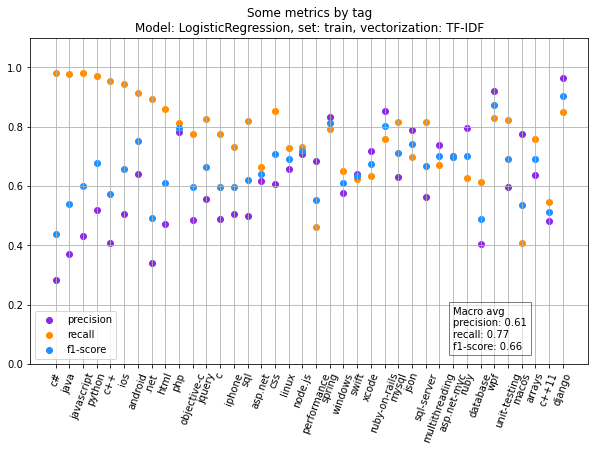

In [54]:
diplay_and_plot_report(y_train, y_pred_train, 'LogisticRegression', 'train', 'TF-IDF')

Classifier: LogisticRegression	Dataset: test
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.25      0.96      0.40       467
          java       0.33      0.93      0.48       430
    javascript       0.42      0.92      0.57       409
        python       0.45      0.93      0.60       354
           c++       0.34      0.86      0.49       293
           ios       0.46      0.86      0.60       285
       android       0.57      0.80      0.67       249
          .net       0.25      0.67      0.37       239
          html       0.47      0.70      0.57       206
           php       0.73      0.63      0.67       164
   objective-c       0.30      0.48      0.37       147
        jquery       0.53      0.75      0.62       150
             c       0.33      0.53      0.40       131
        iphone       0.40      0.59      0.47       134
           sql       0.49      0.72      0.

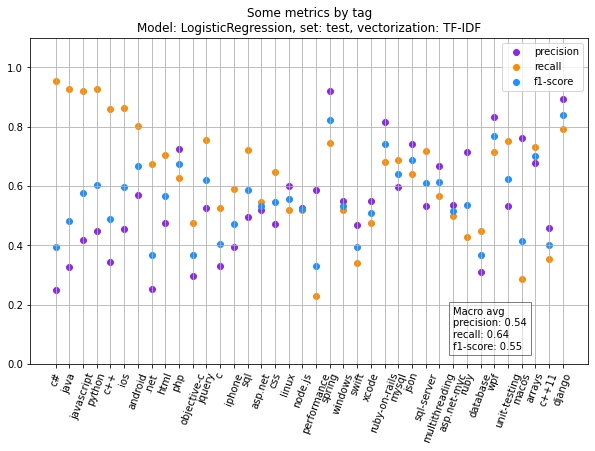

In [55]:
diplay_and_plot_report(y_test, y_pred_test, 'LogisticRegression', 'test','TF-IDF')

In [31]:
fpr, tpr, roc_auc = compute_roc_data(y_train,y_pred_train_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.97
Macro-averaged One-vs-Rest ROC AUC score:
0.98


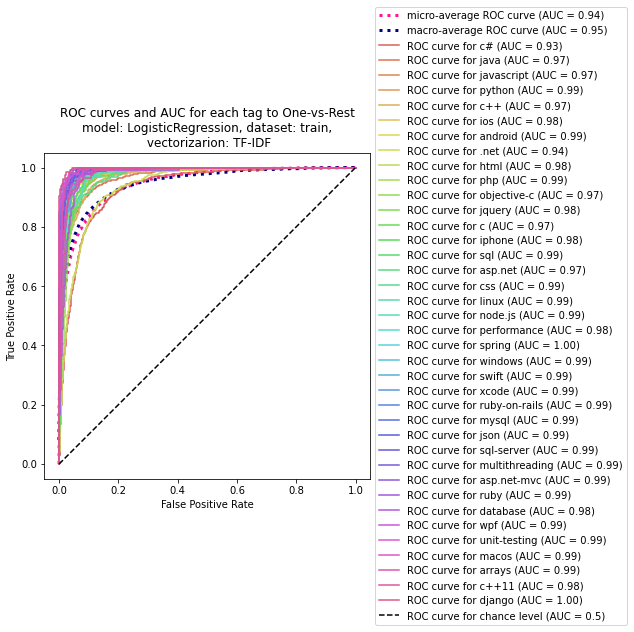

In [58]:
plot_roc_curves(
    fpr,tpr,roc_auc,'LogisticRegression', 'train', 'TF-IDF',y_train, y_pred_train_proba)

In [59]:
fpr, tpr, roc_auc = compute_roc_data(y_test,y_pred_test_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.94
Macro-averaged One-vs-Rest ROC AUC score:
0.95


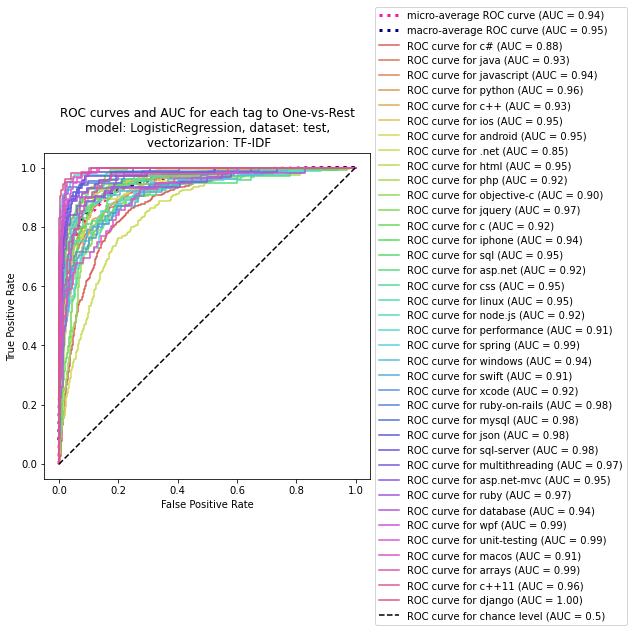

In [61]:
plot_roc_curves(
    fpr,tpr,roc_auc,'LogisticRegression', 'test', 'TF-IDF',y_test, y_pred_test_proba)

In [38]:
# Appending results for later compare
append_results(vectorization='TF-IDF',
               model='LogisticRegression', 
               f1=f1_sco, 
               auc=roc_auc_res,
               fittime=fittime)

In [39]:
classification_results

{'Vectorization': ['TF-IDF'],
 'Model': ['LogisticRegression'],
 'Macro. avg. f1-score': [0.55],
 'Macro. avg. AUC': [0.95],
 'Fit time': [0.84]}

### Naive-Bayes classifier (TD-IDF)

In [ ]:
parameters = {
    'estimator__alpha' : [0.05, 0.2, 0.5, 1],
    'estimator__fit_prior' : [True, False]
}

# Instantiating OneVsRest Classifier
cl = OneVsRestClassifier(MultinomialNB())

# Grid search for best hyperparameters
grid_search = GridSearchCV(
    estimator = cl,
    param_grid= parameters,
    scoring='roc_auc_ovr',
    verbose=2,
    n_jobs=-1
)

# Performing grid search
grid_search.fit(X_train, y_train)

# Instantiating Best OneVsRest Classifier
cl = grid_search.best_estimator_

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
print(f'fit time: {finish - start} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

# Print best parameters
print('The best parameters are:')
print(grid_search.best_params_)
print('The best score is:')
print(grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   0.3s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   0.3s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   0.5s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   0.5s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   0.6s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   0.6s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   0.7s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   0.7s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   0.5s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   0.4s
[CV] END ....estimator__alpha=0.2, estimator__fit_prior=True; total time=   0.3s
[CV] END ....estimator__alpha=0.2, estimator__fit

In [ ]:
# Choosing best threshold for classification
thresh = choose_best_thres(y_train, y_pred_train_proba)

# predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.2


#### Evaluation: NaiveBayes

Classifier: MultinomialNB	Dataset: train
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       0.61      0.87      0.72      4019
        java       0.67      0.81      0.73      3584
  javascript       0.64      0.87      0.74      3119
      python       0.75      0.89      0.81      3092
         c++       0.65      0.85      0.73      2496
         ios       0.74      0.85      0.79      2208
     android       0.75      0.82      0.79      1928
        .net       0.50      0.61      0.55      2060
        html       0.53      0.76      0.63      1382
         php       0.81      0.75      0.78      1317

   micro avg       0.66      0.82      0.73     25205
   macro avg       0.66      0.81      0.73     25205
weighted avg       0.66      0.82      0.73     25205
 samples avg       0.71      0.84      0.74     25205



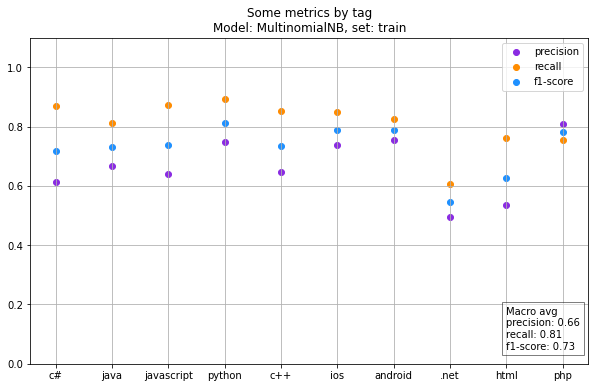

In [ ]:
diplay_and_plot_report(y_train, y_pred_train, 'MultinomialNB', 'train', 'TF-IDF')

Classifier: MultinomialNB	Dataset: test
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       0.58      0.84      0.69      1920
        java       0.64      0.78      0.70      1761
  javascript       0.63      0.84      0.72      1592
      python       0.71      0.86      0.78      1430
         c++       0.63      0.80      0.71      1276
         ios       0.70      0.78      0.74      1123
     android       0.72      0.80      0.76       974
        .net       0.44      0.50      0.47      1002
        html       0.53      0.69      0.60       745
         php       0.80      0.69      0.74       634

   micro avg       0.63      0.78      0.70     12457
   macro avg       0.64      0.76      0.69     12457
weighted avg       0.63      0.78      0.70     12457
 samples avg       0.67      0.80      0.70     12457



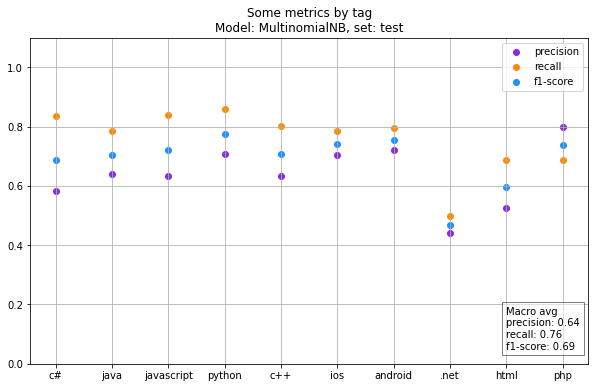

In [ ]:
diplay_and_plot_report(y_test, y_pred_test, 'MultinomialNB', 'test', 'TF-IDF')

In [ ]:
fpr, tpr, roc_auc = compute_roc_data(y_train,y_pred_train_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.96
Macro-averaged One-vs-Rest ROC AUC score:
0.96


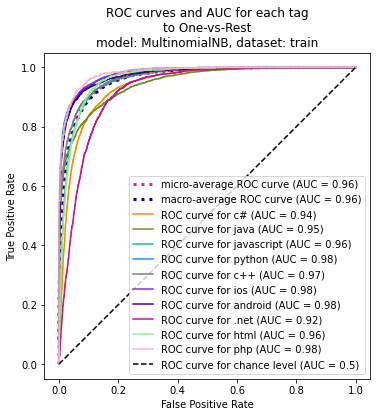

In [ ]:
plot_roc_curves(
    fpr,tpr,roc_auc,'MultinomialNB', 'train','TF-IDF',y_train, y_pred_train_proba)

In [ ]:
fpr, tpr, roc_auc = compute_roc_data(y_test,y_pred_test_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.95
Macro-averaged One-vs-Rest ROC AUC score:
0.94


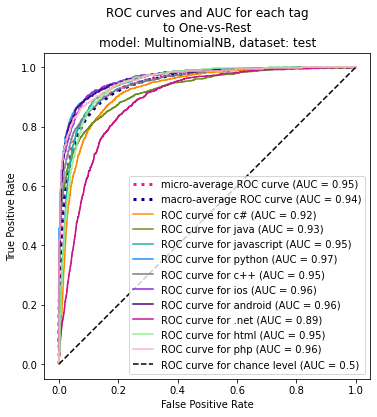

In [ ]:
plot_roc_curves(
    fpr,tpr,roc_auc,'MultinomialNB', 'test','TF-IDF',y_test, y_pred_test_proba)

In [ ]:
# Appending results for later compare
append_results(vectorization='TF-IDF',
               model='MultinomialNB', 
               f1=f1_sco, 
               auc=roc_auc_res,
               fittime=fittime)

### RandomForestClassifier

We tried to fine tune this random forest classifier, but it took so long. One strategy is to execute this random search on google collab. For the moment we leave the search as a commented cell and we use the default hyperparameters to compare.

In [ ]:
# # Hyperparameter tuning for RandomForest

# parameters = {
#     'estimator__n_estimators' : [50, 100, 150, 200, 250],
#     'estimator__max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
#     'estimator__min_samples_split' : [2,5,10],
#     'estimator__min_samples_leaf' : [1,2,4],
#     'estimator__bootstrap' : [True, False],
#     'estimator__max_features' : ['sqrt', 'log2', None]
# }

# # Instantiating OneVsRest Classifier
# cl = OneVsRestClassifier(RandomForestClassifier())

# # Random search for best hyperparameters
# random_search = RandomizedSearchCV(
#     estimator = cl,
#     param_distributions= parameters,
#     n_iter=30,
#     scoring='roc_auc_ovr',
#     verbose=2,
#     random_state=5,
#     n_jobs=-1
# )

# # Perform random search
# random_search.fit(X_train, y_train)

# # Instantiating OneVsRest Classifier default parameters
# cl = random_search.best_estimator_

# # Fitting classifier
# start = time.time()
# cl.fit(X_train,y_train)
# finish = time.time()
# print(f'fit time: {finish - start} secs.')

# # Predicting (with probabilites)
# start = time.time()
# y_pred_train_proba = cl.predict_proba(X_train)
# finish = time.time()
# print(f'predict time: {finish - start} secs.')

# y_pred_test_proba = cl.predict_proba(X_test)

# # Print best parameters
# print('The best parameters are:')
# print(random_search.best_params_)
# print('The best score is:')
# print(random_search.best_score_)


In [ ]:
# Instantiating OneVsRest Classifier default parameters
cl = OneVsRestClassifier(RandomForestClassifier())

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
print(f'fit time: {finish - start} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

fit time: 152.28099942207336 secs.
predict time: 11.860923051834106 secs.


In [ ]:
# choose threshold for maximal f1-score
thresh = choose_best_thres(y_train, y_pred_train_proba)

# predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.5


#### Evaluation: RandomForestClassifier

Classifier: RandomForestClassifier	Dataset: train
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       1.00      1.00      1.00      4019
        java       1.00      1.00      1.00      3584
  javascript       1.00      1.00      1.00      3119
      python       1.00      1.00      1.00      3092
         c++       1.00      1.00      1.00      2496
         ios       1.00      1.00      1.00      2208
     android       1.00      1.00      1.00      1928
        .net       1.00      1.00      1.00      2060
        html       1.00      1.00      1.00      1382
         php       1.00      1.00      1.00      1317

   micro avg       1.00      1.00      1.00     25205
   macro avg       1.00      1.00      1.00     25205
weighted avg       1.00      1.00      1.00     25205
 samples avg       1.00      1.00      1.00     25205



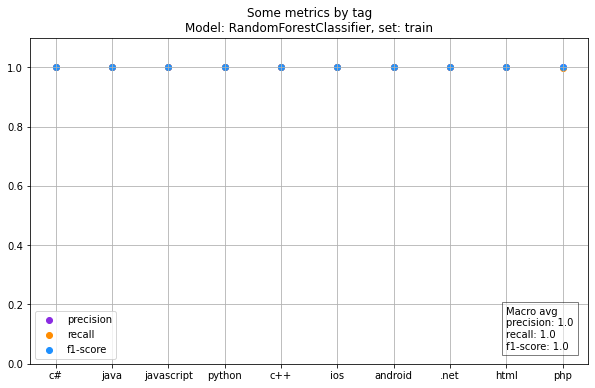

In [ ]:
diplay_and_plot_report(y_train, y_pred_train, 'RandomForestClassifier', 'train', 'TF-IDF')

Classifier: RandomForestClassifier	Dataset: test
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       0.79      0.52      0.63      1920
        java       0.88      0.71      0.79      1761
  javascript       0.83      0.72      0.77      1592
      python       0.95      0.83      0.88      1430
         c++       0.91      0.54      0.68      1276
         ios       0.91      0.77      0.83      1123
     android       0.90      0.79      0.84       974
        .net       0.67      0.11      0.19      1002
        html       0.76      0.32      0.45       745
         php       0.91      0.74      0.82       634

   micro avg       0.87      0.62      0.72     12457
   macro avg       0.85      0.60      0.69     12457
weighted avg       0.85      0.62      0.70     12457
 samples avg       0.67      0.65      0.65     12457



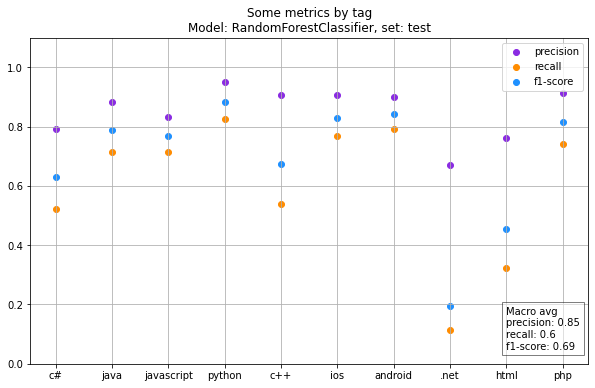

In [ ]:
diplay_and_plot_report(y_test, y_pred_test, 'RandomForestClassifier', 'test', 'TF-IDF')

In [ ]:
fpr, tpr, roc_auc = compute_roc_data(y_train,y_pred_train_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
1.00
Macro-averaged One-vs-Rest ROC AUC score:
1.00


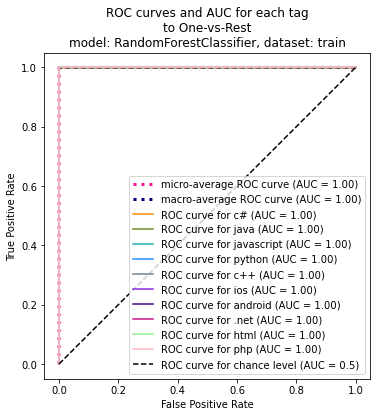

In [ ]:
plot_roc_curves(
    fpr,tpr,roc_auc,'RandomForestClassifier', 'train','TF-IDF',y_train, y_pred_train_proba)

In [ ]:
fpr, tpr, roc_auc = compute_roc_data(y_test,y_pred_test_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.94
Macro-averaged One-vs-Rest ROC AUC score:
0.94


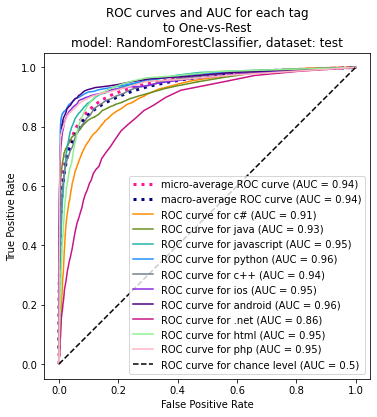

In [ ]:
plot_roc_curves(
    fpr,tpr,roc_auc,'RandomForestClassifier', 'test','TF-IDF',y_test, y_pred_test_proba)

In [ ]:
# Appending results for later compare
append_results(vectorization='TF-IDF',
               model='RandomForestCl', 
               f1=f1_sco, 
               auc=roc_auc_res,
               fittime=fittime)

# Word2vec (Supervised)

The steps of this part of the processing + modeling + classification are:

* We create and train a Word2Vec model with our sentences/processed text. This model provides a **vocabulary**.
  
* From this **vocabulary** and with [**tensorflow.keras.preprocessing.text.Tokenizer**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) we create an **index** for our vocabulary and turn each of our sentences into a padded **sequence** of length 33 (the mean of the length of sentences) assigning each word on the sentence to their index.

* We then create an **Embedding matrix** where each row corresponds to a word of our vocabulary and is a vector of dimension 300 provided by our Word2Vec trained model.

* Then we create a tensorflow.keras model with an [**Embedding layer**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) and our embedding matrix as weights. This model uses [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) to make an average of the embeddings.

* Finally we use the embedding model to predict in our sentences/processed text and this gives us a feature matrix, ready to be splitted in train/test sets and we perform different classifications models.

In [ ]:
# Calulating some statistics for the length (in # of words) of our sentences
df.processed_text.apply(lambda x:len(x.split())).describe()

count    31928.000000
mean        32.543535
std         23.032481
min          1.000000
25%         17.000000
50%         27.000000
75%         41.000000
max        371.000000
Name: processed_text, dtype: float64

The mean is 32 words per sentence, we choose this value as `maxlen`.

Creation and training of the Word2Vec model:

In [ ]:
# Build & train Word2Vec model
print("Build & train Word2Vec model ...")

# Word2Vec model parameters
w2v_size=300
w2v_window=5
w2v_min_count=30
w2v_epochs=100 
maxlen = 32 # adapt to length of sentences
sentences = df['processed_text'].to_list()
sentences = [text.split() for text in sentences]

# Instantiate model
w2v_model = gensim.models.Word2Vec(vector_size=w2v_size,
                                   window=w2v_window,
                                   min_count=w2v_min_count, 
                                    # max_final_vocab=2000,
                                   workers=1)
# Building vocabulary
w2v_model.build_vocab(sentences)

# Training the model
w2v_model.train(sentences, 
                total_examples=w2v_model.corpus_count, # Since = sentences to build
                epochs=w2v_epochs)

# Model vectors (words <--> embeddings)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key

print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

# Save/load model
# model_vectors.save('word2vecV1.wordvectors')  # Store
# model_vectors = KeyedVectors.load('word2vecV1.wordvectors', mmap='r')  # Load

Build & train Word2Vec model ...
Vocabulary size: 2639
Word2Vec trained


In [ ]:
# Display some words of our vocabulary
print(f'The first 15 words of our vocabulary are:\n {w2v_words[:15]}')

The first 15 words of our vocabulary are:
 ['code', 'file', 'way', 'error', 'class', 'method', 'problem', 'app', 'application', 'function', 'object', 'user', 'time', 'example', 'value']


In [ ]:
# Inserting a non-word
w2v_words.insert(0,'')
w2v_words[:15]

['',
 'code',
 'file',
 'way',
 'error',
 'class',
 'method',
 'problem',
 'app',
 'application',
 'function',
 'object',
 'user',
 'time',
 'example']

In [ ]:
# display the first 10 coordinates of the word python in our vocab.
print(f"Example: The first 10 coordinates of the vector associated to the word python:\n {model_vectors['python'][:10]}")

Example: The first 10 coordinates of the vector associated to the word python:
 [-0.9578248   0.25237042  0.691986   -0.35974488  0.73955846 -0.59103465
  1.427604   -0.32554922 -0.6710663  -0.02303623]


In [ ]:
# Display the most similar words to 'python'
print('The most similar words to python are:')
w2v_model.wv.most_similar('python')

The most similar words to python are:


[('ball', 0.4245394468307495),
 ('registry', 0.40321311354637146),
 ('o(n', 0.3876746892929077),
 ('edge', 0.3690236210823059),
 ('preview', 0.35463911294937134),
 ('assertion', 0.35058167576789856),
 ('add', 0.346490740776062),
 ('kernel', 0.34044626355171204),
 ('restful', 0.3346766233444214),
 ('disk', 0.33080270886421204)]

We prepare the sentences from our processed text.

In [ ]:
# Creation of index with our vocabulary
tokenizer = Tokenizer(filters='\t\n') # tensorflow.keras.preprocessing.text
# Updating internal vocabulary (create word index from our vocabulary)
tokenizer.fit_on_texts(w2v_words)

# Printing summary
print(f'# of words in our vocabulary: {len(w2v_words)}')
print(f'# of words in our tokenizer.word_index: {len(tokenizer.word_index)}')
print('First 5 words in our vocabulary:')
print(' ', w2v_words[:5])
print('First 5 words in tokenizer.word_index')
print(' ', list(tokenizer.word_index.items())[:5])


# of words in our vocabulary: 2640
# of words in our tokenizer.word_index: 2639
First 5 words in our vocabulary:
  ['', 'code', 'file', 'way', 'error']
First 5 words in tokenizer.word_index
  [('code', 1), ('file', 2), ('way', 3), ('error', 4), ('class', 5)]


In [ ]:
# Transforming each sentence to a sequence (following tokenizer.word_index)
sequences = tokenizer.texts_to_sequences(sentences)

# Padding sequences so they all have the same length
x_sentences = pad_sequences(sequences,
                            maxlen=maxlen,
                            padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print(f'Number of unique words: {num_words}\n')

print('Example:')
print(f'The sentence {sentences[0]},')
print(f'Corresponding to {sequences[0]}')
print(f'becomes the sequence: {x_sentences[0]}')

Number of unique words: 2640

Example:
The sentence ['decimal', 'c#', 'variable', 'opacity', 'app', 'error', 'type'],
Corresponding to [1762, 46, 68, 1464, 8, 4, 21]
becomes the sequence: [1762   46   68 1464    8    4   21    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


We now create the **embedding matrix** of our vocabulary

In [ ]:
# Creation of the embedding matrix
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print(f'Embedding matrix size : {embedding_matrix.shape}')

Word embedding rate :  1.0
Embedding matrix size : (2640, 300)


We are now ready to create the **embedding model**

In [ ]:
# Creation of model
input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')

# Creation of the embedding
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights=[embedding_matrix],
                         input_length=maxlen)(word_input)

word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 32, 300)           792000    
                                                                 
 global_average_pooling1d_3   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 792,000
Trainable params: 792,000
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Model execution: getting the embeddings for our documents
embeddings = embed_model.predict(x_sentences)
print(f'The embedding shape of our documents is: {embeddings.shape}')

998/998 [==============================] - 2s 2ms/step
The embedding shape of our documents is: (31928, 300)


We can now obtain our **feature matrix**:

In [ ]:
X = embeddings

# Defining target vector
columns_tags = ['tag_'+tag for tag in tag_list]
y = df[columns_tags]

# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.33, random_state=5
)

## Classification

### Logistic Regression

In [ ]:
# Hyperparameters for logistic regression
parameters = {
    'estimator__penalty' : ['l1', 'l2', 'elasticnet'],
    'estimator__dual' : [True, False],
    'estimator__tol' : [1e-6, 1e-5, 1e-4],
    'estimator__C' : [0.05 ,0.1, 0.5, 0.7, 1],
    'estimator__fit_intercept' : [True, False],
    'estimator__solver' : ['liblinear','sag', 'saga'],
    'estimator__l1_ratio' : [0.3, 0.5, 0.7]
}

# Instantiating OneVsRest Classifier
cl = OneVsRestClassifier(LogisticRegression())

# Random search for best hyperparameters
random_search = RandomizedSearchCV(
    estimator = cl,
    param_distributions= parameters,
    n_iter=20,
    scoring='roc_auc_ovr',
    random_state=5,
    n_jobs=-1
)

# Perform random search
random_search.fit(X_train, y_train)

# Instantiating BEST OneVsRest Classifier
cl = random_search.best_estimator_

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
print(f'fit time: {finish - start} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

/home/ana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ana/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/ana/.local/lib/pyth

fit time: 21.927311420440674 secs.
predict time: 0.43839550018310547 secs.


In [ ]:
# Print best parameters
print('The best parameters are:')
print(random_search.best_params_)
print('The best score is:')
print(random_search.best_score_)

The best parameters are:
{'estimator__tol': 1e-05, 'estimator__solver': 'liblinear', 'estimator__penalty': 'l1', 'estimator__l1_ratio': 0.7, 'estimator__fit_intercept': True, 'estimator__dual': False, 'estimator__C': 0.7}
The best score is:
0.9442194064268616


In [ ]:
thresh = choose_best_thres(y_train, y_pred_train_proba)

# Predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.3


Classifier: LogisticRegression	Dataset: train
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       0.71      0.79      0.74      4019
        java       0.75      0.75      0.75      3584
  javascript       0.74      0.78      0.76      3119
      python       0.83      0.84      0.84      3092
         c++       0.81      0.82      0.82      2496
         ios       0.83      0.82      0.83      2208
     android       0.84      0.80      0.82      1928
        .net       0.50      0.44      0.47      2060
        html       0.63      0.62      0.62      1382
         php       0.80      0.74      0.77      1317

   micro avg       0.75      0.76      0.75     25205
   macro avg       0.74      0.74      0.74     25205
weighted avg       0.75      0.76      0.75     25205
 samples avg       0.72      0.78      0.73     25205



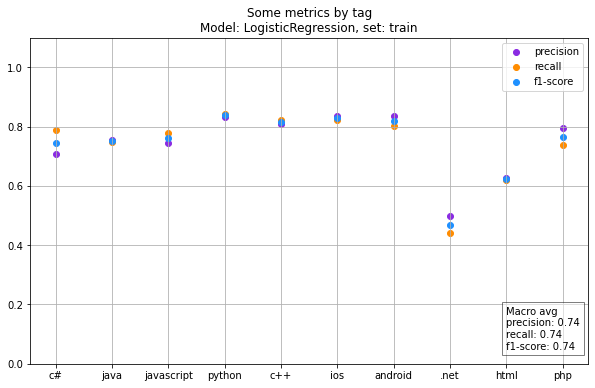

In [ ]:
diplay_and_plot_report(y_train, y_pred_train, 'LogisticRegression', 'train', 'Word2Vec')

Classifier: LogisticRegression	Dataset: test
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       0.69      0.78      0.73      1920
        java       0.73      0.72      0.73      1761
  javascript       0.74      0.75      0.74      1592
      python       0.80      0.83      0.82      1430
         c++       0.81      0.80      0.81      1276
         ios       0.79      0.78      0.79      1123
     android       0.80      0.79      0.80       974
        .net       0.48      0.42      0.45      1002
        html       0.64      0.57      0.60       745
         php       0.75      0.70      0.72       634

   micro avg       0.73      0.73      0.73     12457
   macro avg       0.72      0.71      0.72     12457
weighted avg       0.73      0.73      0.73     12457
 samples avg       0.70      0.75      0.71     12457



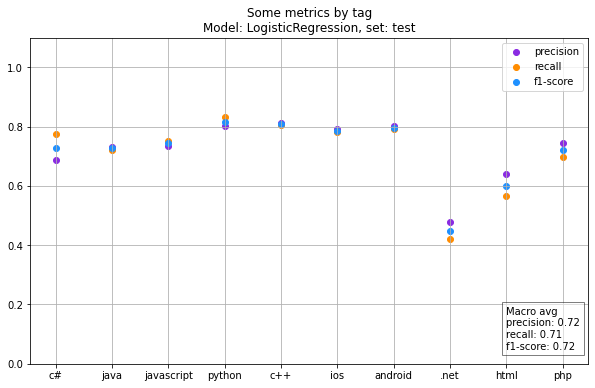

In [ ]:
diplay_and_plot_report(y_test, y_pred_test, 'LogisticRegression', 'test','Word2Vec')

In [ ]:
fpr, tpr, roc_auc = compute_roc_data(y_train,y_pred_train_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.96
Macro-averaged One-vs-Rest ROC AUC score:
0.96


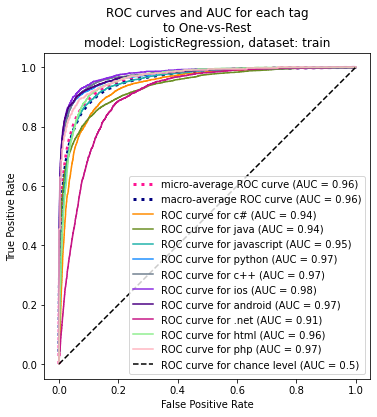

In [ ]:
plot_roc_curves(
    fpr,tpr,roc_auc,'LogisticRegression', 'train','Word2Vec',y_train, y_pred_train_proba)

In [ ]:
fpr, tpr, roc_auc = compute_roc_data(y_test,y_pred_test_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.95
Macro-averaged One-vs-Rest ROC AUC score:
0.94


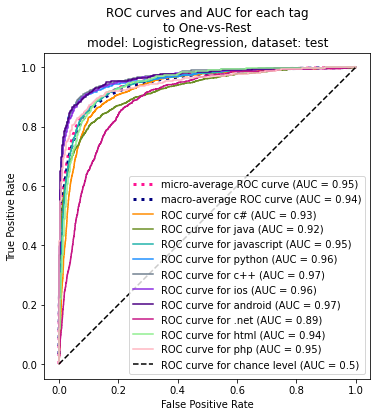

In [ ]:
plot_roc_curves(
    fpr,tpr,roc_auc,'LogisticRegression', 'test','Word2Vec',y_test, y_pred_test_proba)

In [ ]:
# Appending results for later compare
append_results(vectorization='Word2Vec',
               model='LogisticRegression', 
               f1=f1_sco, 
               auc=roc_auc_res,
               fittime=fittime)

### Naive-Bayes classifier (TD-IDF)

This classifier does not take negative numbers as an argument for the feature matrix. We then scale the data with min-max scaler to have them between 0 and 1.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X = embeddings

# Scaling data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Defining target vector
columns_tags = ['tag_'+tag for tag in tag_list]
y = df[columns_tags]

# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,y, test_size=0.33, random_state=5
)

In [ ]:
parameters = {
    'estimator__alpha' : [0.05, 0.2, 0.5, 1],
    'estimator__fit_prior' : [True, False]
}

# Instantiating OneVsRest Classifier
cl = OneVsRestClassifier(MultinomialNB())

# Grid search for best hyperparameters
grid_search = GridSearchCV(
    estimator = cl,
    param_grid= parameters,
    scoring='roc_auc_ovr',
    verbose=2,
    n_jobs=-1
)

# Performing grid search
grid_search.fit(X_train, y_train)

# Instantiating Best OneVsRest Classifier
cl = grid_search.best_estimator_

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
print(f'fit time: {finish - start} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

# Print best parameters
print('The best parameters are:')
print(grid_search.best_params_)
print('The best score is:')
print(grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   2.1s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   2.4s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   2.6s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   2.8s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   2.8s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   3.2s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   3.2s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=   3.6s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   2.0s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=   2.1s
[CV] END ....estimator__alpha=0.2, estimator__fit_prior=True; total time=   2.3s
[CV] END ....estimator__alpha=0.2, estimator__fit

In [ ]:
# Choosing best threshold for classification
thresh = choose_best_thres(y_train, y_pred_train_proba)

# predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.1


#### Evaluation: NaiveBayes

Classifier: MultinomialNB	Dataset: train
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       0.19      1.00      0.32      4019
        java       0.17      1.00      0.29      3584
  javascript       0.21      0.98      0.34      3119
      python       0.17      1.00      0.29      3092
         c++       0.35      0.89      0.50      2496
         ios       0.39      0.77      0.52      2208
     android       0.39      0.66      0.49      1928
        .net       0.25      0.61      0.36      2060
        html       0.42      0.52      0.47      1382
         php       0.40      0.19      0.26      1317

   micro avg       0.22      0.84      0.35     25205
   macro avg       0.29      0.76      0.38     25205
weighted avg       0.26      0.84      0.37     25205
 samples avg       0.22      0.85      0.34     25205



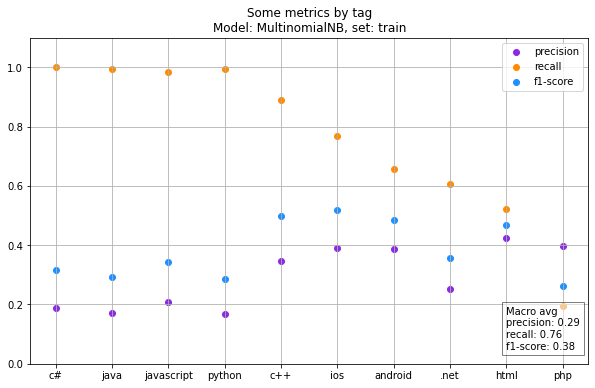

In [ ]:
diplay_and_plot_report(y_train, y_pred_train, 'MultinomialNB', 'train','Word2Vec')

Classifier: MultinomialNB	Dataset: test
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       0.18      1.00      0.31      1920
        java       0.17      1.00      0.29      1761
  javascript       0.21      0.99      0.35      1592
      python       0.16      0.99      0.27      1430
         c++       0.36      0.88      0.51      1276
         ios       0.39      0.76      0.51      1123
     android       0.40      0.68      0.50       974
        .net       0.25      0.58      0.35      1002
        html       0.44      0.52      0.48       745
         php       0.43      0.21      0.28       634

   micro avg       0.22      0.84      0.35     12457
   macro avg       0.30      0.76      0.39     12457
weighted avg       0.27      0.84      0.37     12457
 samples avg       0.22      0.85      0.34     12457



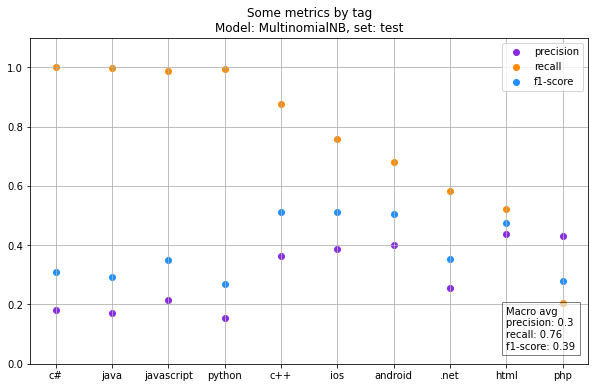

In [ ]:
diplay_and_plot_report(y_test, y_pred_test, 'MultinomialNB', 'test','Word2Vec')

In [ ]:
fpr, tpr, roc_auc = compute_roc_data(y_train,y_pred_train_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.82
Macro-averaged One-vs-Rest ROC AUC score:
0.87


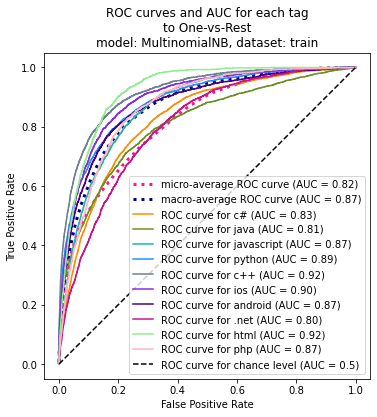

In [ ]:
plot_roc_curves(
    fpr,tpr,roc_auc,'MultinomialNB', 'train','Word2Vec',y_train, y_pred_train_proba)

In [ ]:
fpr, tpr, roc_auc = compute_roc_data(y_test,y_pred_test_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.82
Macro-averaged One-vs-Rest ROC AUC score:
0.87


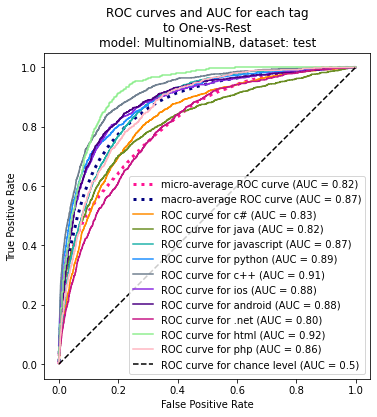

In [ ]:
plot_roc_curves(
    fpr,tpr,roc_auc,'MultinomialNB', 'test','Word2Vec',y_test, y_pred_test_proba)

In [ ]:
# Appending results for later compare
append_results(vectorization='Word2Vec',
               model='MultinomialNB', 
               f1=f1_sco, 
               auc=roc_auc_res,
               fittime=fittime)

### RandomForest


In [ ]:
X = embeddings

# Defining target vector
columns_tags = ['tag_'+tag for tag in tag_list]
y = df[columns_tags]

# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.33, random_state=5
)

In [ ]:
# Instantiating OneVsRest Classifier default parameters
cl = OneVsRestClassifier(RandomForestClassifier())

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
print(f'fit time: {finish - start} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

fit time: 405.3857202529907 secs.
predict time: 6.609480857849121 secs.


In [ ]:
# choose threshold for maximal f1-score
thresh = choose_best_thres(y_train, y_pred_train_proba)

# predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.4


#### Evaluation: RandomForestClassifier

Classifier: RandomForestClassifier	Dataset: train
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       1.00      1.00      1.00      4019
        java       1.00      1.00      1.00      3584
  javascript       1.00      1.00      1.00      3119
      python       1.00      1.00      1.00      3092
         c++       1.00      1.00      1.00      2496
         ios       1.00      1.00      1.00      2208
     android       1.00      1.00      1.00      1928
        .net       1.00      1.00      1.00      2060
        html       1.00      1.00      1.00      1382
         php       1.00      1.00      1.00      1317

   micro avg       1.00      1.00      1.00     25205
   macro avg       1.00      1.00      1.00     25205
weighted avg       1.00      1.00      1.00     25205
 samples avg       1.00      1.00      1.00     25205



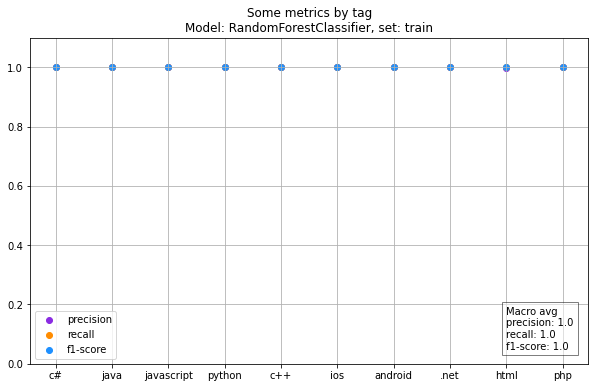

In [ ]:
diplay_and_plot_report(y_train, y_pred_train, 'RandomForestClassifier', 'train','Word2Vec')

Classifier: RandomForestClassifier	Dataset: test
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       0.76      0.49      0.59      1920
        java       0.87      0.40      0.55      1761
  javascript       0.74      0.52      0.61      1592
      python       0.87      0.53      0.66      1430
         c++       0.86      0.59      0.70      1276
         ios       0.89      0.52      0.66      1123
     android       0.90      0.47      0.62       974
        .net       0.54      0.11      0.18      1002
        html       0.69      0.37      0.48       745
         php       0.93      0.19      0.32       634

   micro avg       0.81      0.44      0.57     12457
   macro avg       0.81      0.42      0.54     12457
weighted avg       0.81      0.44      0.56     12457
 samples avg       0.47      0.46      0.46     12457



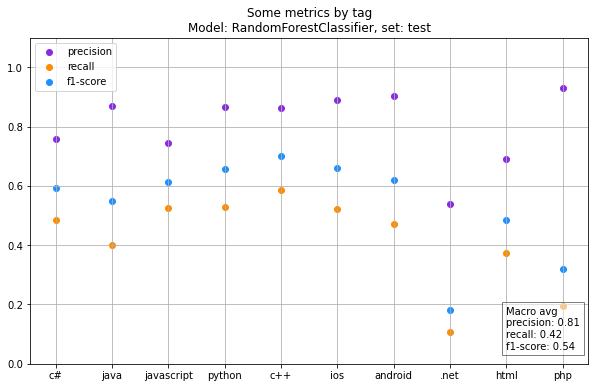

In [ ]:
diplay_and_plot_report(y_test, y_pred_test, 'RandomForestClassifier', 'test','Word2Vec')

In [ ]:
fpr, tpr, roc_auc = compute_roc_data(y_train,y_pred_train_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
1.00
Macro-averaged One-vs-Rest ROC AUC score:
1.00


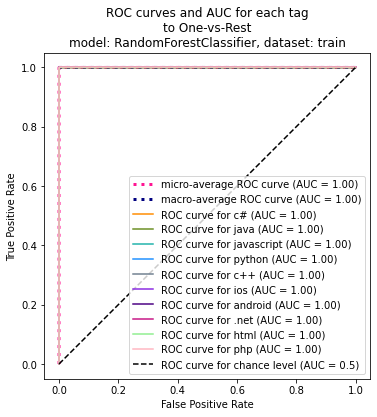

In [ ]:
plot_roc_curves(
    fpr,tpr,roc_auc,'RandomForestClassifier', 'train','Word2Vec',y_train, y_pred_train_proba)

In [ ]:
fpr, tpr, roc_auc = compute_roc_data(y_test,y_pred_test_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.91
Macro-averaged One-vs-Rest ROC AUC score:
0.90


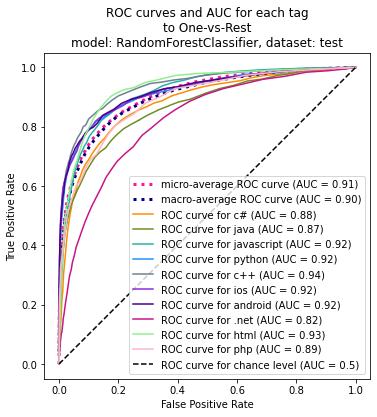

In [ ]:
plot_roc_curves(
    fpr,tpr,roc_auc,'RandomForestClassifier', 'test','Word2Vec',y_test, y_pred_test_proba)

In [ ]:
# Appending results for later compare
append_results(vectorization='Word2Vec',
               model='RandomForest', 
               f1=f1_sco, 
               auc=roc_auc_res,
               fittime=fittime)

# BERT (Supervised)

In [12]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.11.0
2.11.0
Num GPUs Available:  1
True


## Preparation fonctions

In [13]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot # juste besoin du 1er

Model: 'bert-base-uncased'

In [14]:
max_length = 64 # ma taille moyenne 
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)

# pour moi
# from transformers import AutoTokenizer, BertModel
# model = BertModel.from_pretrained("bert-base-uncased")

sentences = df['processed_text'].to_list()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tf_model.h5
Som

In [15]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file to

1/1 [==============================] - 0s 27ms/step
temps traitement :  542.0


In [17]:
type(features_bert)

numpy.ndarray

In [18]:
np.save('features_bert.npy', features_bert) # save
# feats_bert = np.load('features_bert.npy')  # load 

In [20]:
df.to_csv('sample_for_bert.csv')

We obtain our feature matrix:

In [21]:
X = features_bert

# Defining target vector
columns_tags = ['tag_'+tag for tag in tag_list]
y = df[columns_tags]

# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.33, random_state=5
)

## Classification

### Logistic Regression

In [22]:
# Hyperparameters for logistic regression
parameters = {
    'estimator__penalty' : ['l1', 'l2', 'elasticnet'],
    'estimator__dual' : [True, False],
    'estimator__tol' : [1e-6, 1e-5, 1e-4],
    'estimator__C' : [0.05 ,0.1, 0.5, 0.7, 1],
    'estimator__fit_intercept' : [True, False],
    'estimator__solver' : ['liblinear','sag', 'saga'],
    'estimator__l1_ratio' : [0.3, 0.5, 0.7]
}

# Instantiating OneVsRest Classifier
cl = OneVsRestClassifier(LogisticRegression())

# Random search for best hyperparameters
random_search = RandomizedSearchCV(
    estimator = cl,
    param_distributions= parameters,
    n_iter=20,
    scoring='roc_auc_ovr',
    random_state=5,
    n_jobs=-1
)

# Perform random search
random_search.fit(X_train, y_train)

# Instantiating BEST OneVsRest Classifier
cl = random_search.best_estimator_

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
print(f'fit time: {finish - start} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

fit time: 70.0498321056366 secs.
predict time: 0.06488466262817383 secs.


In [23]:
# Print best parameters
print('The best parameters are:')
print(random_search.best_params_)
print('The best score is:')
print(random_search.best_score_)

The best parameters are:
{'estimator__tol': 1e-05, 'estimator__solver': 'saga', 'estimator__penalty': 'l2', 'estimator__l1_ratio': 0.5, 'estimator__fit_intercept': True, 'estimator__dual': False, 'estimator__C': 0.7}
The best score is:
0.8898725149273392


In [24]:
thresh = choose_best_thres(y_train, y_pred_train_proba)

# Predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.3


#### Evaluation

Classifier: LogisticRegression	Dataset: train
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       0.67      0.77      0.72      1298
        java       0.68      0.72      0.70      1170
  javascript       0.67      0.70      0.69       968
      python       0.76      0.78      0.77       929
         c++       0.80      0.80      0.80       806
         ios       0.79      0.77      0.78       668
     android       0.81      0.76      0.78       576
        .net       0.55      0.47      0.51       639
        html       0.69      0.67      0.68       465
         php       0.79      0.68      0.73       395

   micro avg       0.71      0.72      0.72      7914
   macro avg       0.72      0.71      0.72      7914
weighted avg       0.71      0.72      0.72      7914
 samples avg       0.67      0.74      0.68      7914



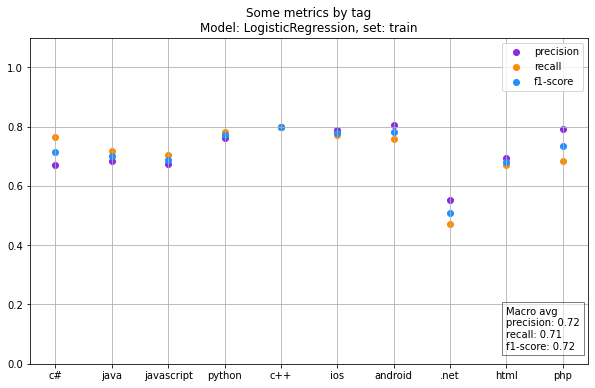

In [25]:
diplay_and_plot_report(y_train, y_pred_train, 'LogisticRegression', 'train','BERT')

Classifier: LogisticRegression	Dataset: test
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       0.55      0.70      0.62       635
        java       0.56      0.58      0.57       526
  javascript       0.59      0.58      0.58       485
      python       0.68      0.67      0.68       485
         c++       0.69      0.75      0.72       387
         ios       0.67      0.67      0.67       333
     android       0.74      0.68      0.71       291
        .net       0.38      0.34      0.36       336
        html       0.55      0.58      0.56       226
         php       0.68      0.53      0.59       199

   micro avg       0.60      0.62      0.61      3903
   macro avg       0.61      0.61      0.61      3903
weighted avg       0.60      0.62      0.61      3903
 samples avg       0.56      0.64      0.57      3903



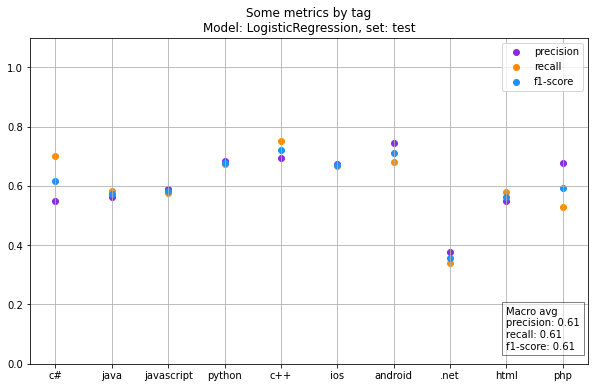

In [26]:
diplay_and_plot_report(y_test, y_pred_test, 'LogisticRegression', 'test','BERT')

In [27]:
fpr, tpr, roc_auc = compute_roc_data(y_train,y_pred_train_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.95
Macro-averaged One-vs-Rest ROC AUC score:
0.95


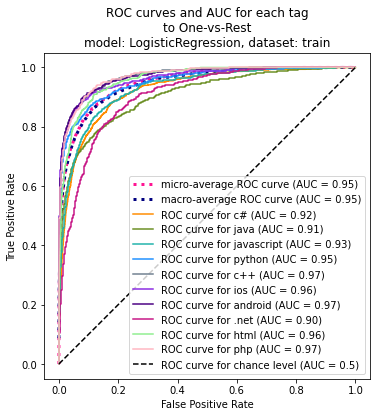

In [28]:
plot_roc_curves(
    fpr,tpr,roc_auc,'LogisticRegression', 'train','BERT',y_train, y_pred_train_proba)

In [29]:
fpr, tpr, roc_auc = compute_roc_data(y_test,y_pred_test_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.90
Macro-averaged One-vs-Rest ROC AUC score:
0.90


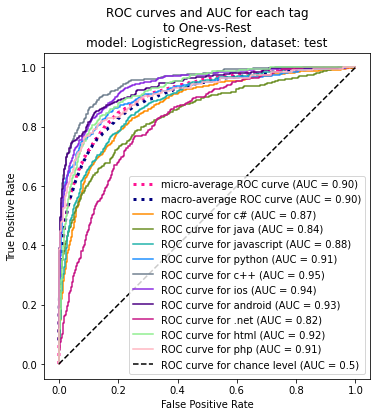

In [30]:
plot_roc_curves(
    fpr,tpr,roc_auc,'LogisticRegression', 'test','BERT',y_test, y_pred_test_proba)

In [ ]:
# Appending results for later compare
append_results(vectorization='BERT',
               model='LogisticRegression', 
               f1=f1_sco, 
               auc=roc_auc_res,
               fittime=fittime)

### Naive-Bayes classifier

This classifier does not take negative numbers as an argument for the feature matrix. We then scale the data with min-max scaler to have them between 0 and 1.

In [31]:
from sklearn.preprocessing import MinMaxScaler

X = features_bert

# Scaling data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Defining target vector
columns_tags = ['tag_'+tag for tag in tag_list]
y = df[columns_tags]

# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,y, test_size=0.33, random_state=5
)

In [32]:
parameters = {
    'estimator__alpha' : [0.05, 0.2, 0.5, 1],
    'estimator__fit_prior' : [True, False]
}

# Instantiating OneVsRest Classifier
cl = OneVsRestClassifier(MultinomialNB())

# Grid search for best hyperparameters
grid_search = GridSearchCV(
    estimator = cl,
    param_grid= parameters,
    scoring='roc_auc_ovr',
    verbose=2,
    n_jobs=-1
)

# Performing grid search
grid_search.fit(X_train, y_train)

# Instantiating Best OneVsRest Classifier
cl = grid_search.best_estimator_

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
print(f'fit time: {finish - start} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

# Print best parameters
print('The best parameters are:')
print(grid_search.best_params_)
print('The best score is:')
print(grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
fit time: 0.6628367900848389 secs.
predict time: 0.8656101226806641 secs.
The best parameters are:
{'estimator__alpha': 0.05, 'estimator__fit_prior': True}
The best score is:
0.7742183454502887


In [33]:
# Choosing best threshold for classification
thresh = choose_best_thres(y_train, y_pred_train_proba)

# predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.2


Evaluation: NaiveBayes

Classifier: MultinomialNB	Dataset: train
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       0.31      0.63      0.41      1298
        java       0.35      0.60      0.44      1170
  javascript       0.28      0.46      0.35       968
      python       0.29      0.46      0.35       929
         c++       0.38      0.65      0.48       806
         ios       0.37      0.63      0.47       668
     android       0.33      0.59      0.42       576
        .net       0.24      0.17      0.20       639
        html       0.34      0.47      0.39       465
         php       0.56      0.14      0.23       395

   micro avg       0.32      0.51      0.40      7914
   macro avg       0.34      0.48      0.37      7914
weighted avg       0.33      0.51      0.39      7914
 samples avg       0.31      0.53      0.36      7914



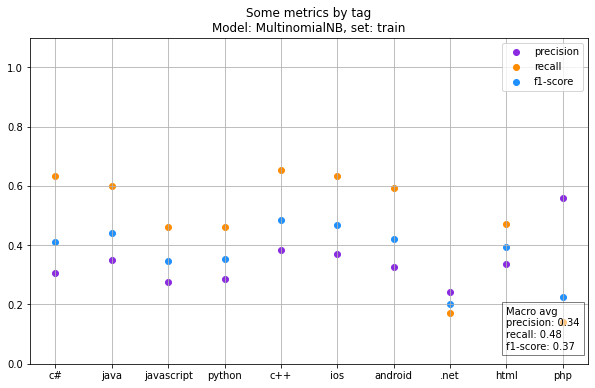

In [34]:
diplay_and_plot_report(y_train, y_pred_train, 'MultinomialNB', 'train','BERT')

Classifier: MultinomialNB	Dataset: test
----------------------------------------------------------------------
              precision    recall  f1-score   support

          c#       0.30      0.64      0.41       635
        java       0.30      0.54      0.38       526
  javascript       0.27      0.43      0.33       485
      python       0.29      0.44      0.35       485
         c++       0.39      0.68      0.49       387
         ios       0.37      0.62      0.47       333
     android       0.35      0.60      0.44       291
        .net       0.25      0.19      0.22       336
        html       0.31      0.45      0.37       226
         php       0.56      0.11      0.18       199

   micro avg       0.32      0.50      0.39      3903
   macro avg       0.34      0.47      0.36      3903
weighted avg       0.32      0.50      0.37      3903
 samples avg       0.30      0.50      0.35      3903



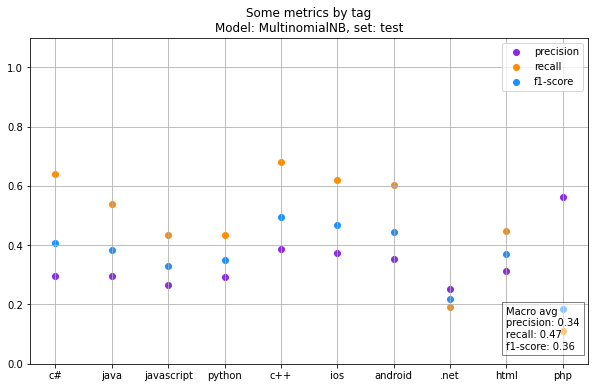

In [35]:
diplay_and_plot_report(y_test, y_pred_test, 'MultinomialNB', 'test','BERT')

In [36]:
fpr, tpr, roc_auc = compute_roc_data(y_train,y_pred_train_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.79
Macro-averaged One-vs-Rest ROC AUC score:
0.78


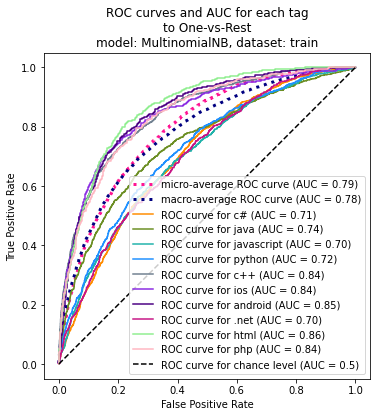

In [37]:
plot_roc_curves(
    fpr,tpr,roc_auc,'MultinomialNB', 'train','BERT',y_train, y_pred_train_proba)

In [38]:
fpr, tpr, roc_auc = compute_roc_data(y_test,y_pred_test_proba, tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.78
Macro-averaged One-vs-Rest ROC AUC score:
0.77


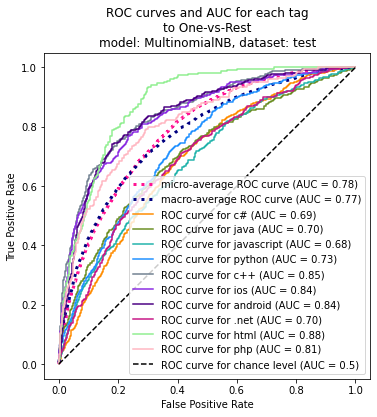

In [39]:
plot_roc_curves(
    fpr,tpr,roc_auc,'MultinomialNB', 'test','BERT',y_test, y_pred_test_proba)

### Random Forest

In [ ]:
X = features_bert

# Defining target vector
columns_tags = ['tag_'+tag for tag in tag_list]
y = df[columns_tags]

# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.33, random_state=5
)